Polyvore
├── disjoint
│   ├── compatibility_test.txt
│   ├── compatibility_train.txt
│   ├── fill_in_blank_test.json
|   └── ...
├── nondisjoint
│   └── ...
└── images
│   ├── XXX.jpg
├── categories.csv
├── polyvore_item_metadata.json
├── polyvore_outfit_titles.json


In [35]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import json

Model preprocess

In [20]:

# Read the CSV file with only the selected columns
df = pd.read_csv('dataset/product_data.csv')
df['url_name'] = df.apply(lambda row: f"Item Description: Color Specification (ESP): {row['des_color_specification_esp']} "\
                                    f"Agrup Color (ENG): {row['des_agrup_color_eng']} "\
                                    f"Sex: {row['des_sex']} "\
                                    f"Age: {row['des_age']} "\
                                    f"Line: {row['des_line']} "\
                                    f"Fabric: {row['des_fabric']} "\
                                    f"Product Category: {row['des_product_category']} "\
                                    f"Product Aggregated Family: {row['des_product_aggregated_family']} "\
                                    f"Product Family: {row['des_product_family']} "\
                                    f"Product Type: {row['des_product_type']}",
                          axis=1)

In [21]:
df = df.rename(columns={
    'des_product_family': 'semantic_category',
    'cod_modelo_color': 'item_id',
    'des_product_aggregated_family': 'category_id',
    'des_product_type': 'product_type'
})
df['categories'] = df[['cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng',
                       'des_sex', 'des_age', 'des_line', 'des_fabric', 'des_product_category']].values.tolist()

df.drop(columns=['cod_color_code', 'des_color_specification_esp', 'des_agrup_color_eng',
                       'des_sex', 'des_age', 'des_line', 'des_fabric', 'des_product_category','des_filename'], inplace=True)
df['description'] = " "
df['title'] = " "


polyvore_item_metadata.json
It contains a dictionary where each key is an item_id, and the values are its associated meta-data labels:
Example:
"165254508": {
        "url_name": "embroidery spaghetti straps tank top", 
        "description": "Shop for Embroidery Spaghetti Straps Tank Top at ZAFUL. Free Shipping And Affordable Prices.", 
        "catgeories": [
            "Women's Fashion", 
            "Clothing", 
            "Tops", 
            "Tank Tops"
        ], 
        "title": "Embroidery Spaghetti Straps Tank Top", 
        "related": [
            "Embroidered top", 
            "Spaghetti-strap tank tops", 
            "Blue top", 
            "Spaghetti strap tank"
        ], 
        "category_id": "104", 
        "semantic_category": "tops"
    }, 

In [24]:
product_data = pd.read_csv('product_data.csv')
#Apply label encoding to each column (a different encoder for each columns)
le_id = LabelEncoder()
le_cat = LabelEncoder()
product_data["item_id"] = le_id.fit_transform(product_data["item_id"])
product_data["category_id"] = le_cat.fit_transform(product_data["category_id"])
product_data.set_index('item_id', inplace=True, drop=True)

# Convert the subset DataFrame to a dictionary
subset_dict = product_data.to_dict(orient='index')

# Save the result as JSON
with open('Polyvore/polyvore_item_metadata.json', 'w') as json_file:
    json.dump(subset_dict, json_file, indent=2)

print("JSON file saved successfully.")
product_data.to_csv('product_data.csv')

JSON file saved successfully.


Rename image files

In [33]:
import os 
def replace_image_path(original_path, new_integer):
    # Split the path into directory and filename
    directory, filename = os.path.split(original_path)
    return directory+f"/{new_integer}.jpg"

product_data = pd.read_csv('product_data.csv')
product_data["cod_modelo_color"] = le_id.transform(product_data["cod_modelo_color"])
for index, row in product_data.iterrows():
    row_dict = row.to_dict()
    item_id = row['cod_modelo_color']
    imagedir = row['des_filename']
    os.rename(imagedir, replace_image_path(imagedir, item_id))

polyvore_outfit_titles.json

It contains a dictionary where each key is an item_id, and the values are its associated meta-data labels.

Example:
    "219779031": {
        "url_name": "spring trend colored denim", 
        "title": "Denim Jumpers"
    }, 
    "211158670": {
        "url_name": "boot scootin outfit only 2500", 
        "title": "Stacked-Heel Boots"
    }, 

In [8]:
import random
import string

outfit_data = pd.read_csv('dataset/outfit_data.csv')
outfit_data['item_id'] = le_id.transform(outfit_data['cod_modelo_color'])
outfit_data = outfit_data.groupby("cod_outfit")["item_id"].agg(list).reset_index().set_index('cod_outfit')
outfit_data.drop(columns=["item_id"], inplace=True)

outfit_data['description'] = ''
def generate_random_string(length=8):
    return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(length))


# Apply the function to fill the 'url_name' column with random strings
outfit_data['url_name'] = df.apply(lambda row: generate_random_string(), axis=1)

# Convert the subset DataFrame to a dictionary
subset_dict = outfit_data.to_dict(orient='index')

# Save the result as JSON
with open('Polyvore/polyvore_outfit_titles.json', 'w') as json_file:
    json.dump(subset_dict, json_file, indent=2)


categories.csv

Each row contains three items: category_id, fine_grained category, semantic categroy

2,undefined,
3,dress,all-body
4,dress,all-body
5,dress,all-body
6,gown,all-body
7,skirt,bottoms

In [10]:
product_data = pd.read_csv('product_data.csv')
product_data = product_data[["category_id","product_type","semantic_category"]]
product_data["category_id"] = le_cat.transform(product_data["category_id"])
product_data.sort_values(by="category_id",inplace=True)
product_data = product_data.drop_duplicates()
product_data.to_csv("Polyvore/categories.csv", index=False, header=False)

train/test/valid.json

A list of outfits, their item_id and their ordering(index).

In [87]:

outfit_data = pd.read_csv('dataset/outfit_data.csv')
outfit_data["cod_modelo_color"] = le_id.transform(outfit_data["cod_modelo_color"])
outfit_data = outfit_data.groupby("cod_outfit")["cod_modelo_color"].agg(list).reset_index()
def transform_row(row):
    set_id = str(row['cod_outfit'])
    items = [{"item_id": str(item), "index": index + 1} for index, item in enumerate(row['cod_modelo_color'])]
    return {"set_id": set_id, "items": items}
# Apply the transformation to each row
transformed_data = outfit_data.apply(transform_row, axis=1).tolist()

# Calculate the number of samples for each split
total_samples = len(transformed_data)
train_samples = int(0.8 * total_samples)
val_samples = int(0.1 * total_samples)

df_train = transformed_data[:train_samples]
df_val = transformed_data[train_samples:train_samples + val_samples]
df_test = transformed_data[train_samples + val_samples:]

my_list = [df_train,df_val,df_test]
filedir = ['Polyvore/nondisjoint/train.json', 'Polyvore/nondisjoint/val.json', 'Polyvore/nondisjoint/test.json']
for i,json_file_path in enumerate(filedir):
    with open(json_file_path, 'w') as json_file:
        json.dump(my_list[i], json_file, indent=2)

compatibility_train/test/valid.txt

Fashion compatibility experiment data, where each row is an outfit sample. The first element of the outfit sample is the label (1/0 for positive/negative) and the remaining elements are item identifiers in that sample.



In [133]:
import random
import numpy as np
# Load JSON data from file
paths = ['Polyvore/nondisjoint/train.json', 'Polyvore/nondisjoint/val.json', 'Polyvore/nondisjoint/test.json']
paths_out = ['Polyvore/nondisjoint/compatibility_train.txt', 'Polyvore/nondisjoint/compatibility_val.txt', 'Polyvore/nondisjoint/compatibility_test.txt']

for i,json_file_path in enumerate(paths):
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)

    # Function to transform each entry
    def transform_entry(entry):
        set_id = entry['set_id']
        items = entry['items']
        transformed_items = [f"{set_id}_{item['index']}" for item in items]
        return ' '.join(['1'] + transformed_items)

    # Apply the transformation to each entry
    transformed_data = [transform_entry(entry) for entry in data]

    # Save the transformed data to a text file
    text_file_path = paths_out[i]
    with open(text_file_path, 'w') as txt_file:
        txt_file.write(''.join(transformed_data))

    #Now add Negative samples
    # Read the text file into a DataFrame
    df = pd.read_csv(text_file_path, sep=' ', header=None, names=['label','col1', 'col2', 'col3', 'col4', 'col5', 'col6', 
    'col7', 'col8', 'col9','col10','col11','col12','col13','col14','col15'])

    for i in range(len(df)):
        random_sample = np.random.binomial(n=8, p=0.4, size=1)
        random_value = 5+int(random_sample[0])
        string = "0 "
        for j in range(random_value):
            try:
                random_entry = df[f'col{j+1}'].dropna().sample().item()
            except ValueError: 
                continue
            string += random_entry + " " 
        string = string.rstrip()

        # Append the string to the text file
        with open(text_file_path, 'a') as txt_file:
            txt_file.write(string + '')

0
Polyvore/nondisjoint/compatibility_train.txt
6273
1
Polyvore/nondisjoint/compatibility_val.txt
784
2
Polyvore/nondisjoint/compatibility_test.txt
785


fill_in_blank_train/test/valid.json

Fill-in-the-blank experiment data, contains an array of dictionaries. These dictionaries contain the question/answer pairs, and also identifies the "index" of the item in the outfit in "blank_position". Since the set_id is used in the item identifiers, the correct answer can be determined by matching the set_id in the question elements with the set_id in the answers.

In [19]:
paths = ['Polyvore/nondisjoint/train.json', 'Polyvore/nondisjoint/val.json', 'Polyvore/nondisjoint/test.json']
paths_out = ['Polyvore/nondisjoint/fill_in_blank_train.json', 'Polyvore/nondisjoint/fill_in_blank_val.json', 'Polyvore/nondisjoint/fill_in_blank_test.json']

def generate_question(series_id):
    # Get set_id
    set_id = series_id["set_id"]
    set_len = len(series_id["items"])

    # Randomly select an item from the "items" list
    selected_item = random.choice(series_id["items"])
    
    # Get item_id and index
    item_id = selected_item["item_id"]
    index = selected_item["index"]
    question_id = list(range(1, set_len + 1))
    question_id.remove(index)
    
    # Construct the question dictionary
    question_dict = {
        "question": [f"{set_id}_{i}" for i in question_id],
        "blank_position": index,
        "answers": [f"{set_id}_{index}"]
    }
    return question_dict


for i,json_file_path in enumerate(paths):
    out_list  = []
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)
    
    for outfit in data:
        out_list.append(generate_question(outfit))

    # Specify the path to your JSON file
    json_file_path = paths_out[i]
    print(json_file_path)
    # Save the list to a JSON file
    with open(json_file_path, 'w') as json_file:
        json.dump(out_list, json_file)

Polyvore/nondisjoint/fill_in_blank_train.json
Polyvore/nondisjoint/fill_in_blank_val.json
Polyvore/nondisjoint/fill_in_blank_test.json


In [6]:


# Specify the columns you want to include
selected_columns = [
    "cod_color_code",
    "des_color_specification_esp",
    "des_agrup_color_eng",
    "des_sex",
    "des_age",
    "des_line",
    "des_fabric",
    "des_product_category",
    "des_product_aggregated_family",
    "des_product_family",
    "des_product_type"
]

# Read the CSV file with only the selected columns
df = pd.read_csv('dataset/product_data.csv', usecols=selected_columns)
descriptions = []
for index, row in df.iterrows():
    category_values = {col: row[col] for col in df.columns}
    description = f"Item Description: "\
                f"Color Specification (ESP): {category_values['des_color_specification_esp']} "\
                f"Agrup Color (ENG): {category_values['des_agrup_color_eng']} "\
                f"Sex: {category_values['des_sex']} "\
                f"Age: {category_values['des_age']} "\
                f"Line: {category_values['des_line']} "\
                f"Fabric: {category_values['des_fabric']} "\
                f"Product Category: {category_values['des_product_category']} "\
                f"Product Aggregated Family: {category_values['des_product_aggregated_family']} "\
                f"Product Family: {category_values['des_product_family']} "\
                f"Product Type: {category_values['des_product_type']} "
    descriptions.append(description)

In [2]:
# import necessary libraries 
import tensorflow_hub as hub 
  
# Load pre-trained universal sentence encoder model 
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") 

In [ ]:
# Sentences for which you want to create embeddings, 
# passed as an array in embed() 
embeddings = embed(descriptions) 
  
# Printing embeddings of each sentence 
#print(embeddings) 
  
# To print each embeddings along with its corresponding  
# sentence below code can be used. 

print(descriptions[1]) 
print(embeddings[1])

In [23]:
with open('test.txt', 'w') as file:
    for i,string in enumerate(descriptions):
        file.write(string + ', ')
        val = str(embeddings[i].numpy().tolist())
        file.write(val[1:-1]+ '\n')

Create the pickle of the semantic categories

In [34]:
import pandas as pd
import itertools
import pickle

df = pd.read_csv('Polyvore/categories.csv')
# Get unique values from the column
unique_values = df.iloc[:, 2].unique()

all_pairs = list(itertools.product(unique_values, repeat=2))

# Specify the path to save the pickle file
pickle_file_path = 'Polyvore/nondisjoint/typespaces.p'

# Save the pairs as a pickle file
with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(all_pairs, pickle_file)

# Display the content of the pickle file
with open(pickle_file_path, 'rb') as pickle_file:
    loaded_pairs = pickle.load(pickle_file)
    print("Loaded Pairs:", loaded_pairs)


Loaded Pairs: [('Hats, scarves and gloves', 'Hats, scarves and gloves'), ('Hats, scarves and gloves', 'Jewellery'), ('Hats, scarves and gloves', 'Footwear'), ('Hats, scarves and gloves', 'Wallets & cases'), ('Hats, scarves and gloves', 'Bags'), ('Hats, scarves and gloves', 'Belts and Ties'), ('Hats, scarves and gloves', 'Glasses'), ('Hats, scarves and gloves', 'Gadgets'), ('Hats, scarves and gloves', 'Intimate'), ('Hats, scarves and gloves', 'Bedding'), ('Hats, scarves and gloves', 'Coats'), ('Hats, scarves and gloves', 'Trenchcoats'), ('Hats, scarves and gloves', 'Puffer coats'), ('Hats, scarves and gloves', 'Parkas'), ('Hats, scarves and gloves', 'Outer Vest'), ('Hats, scarves and gloves', 'Deco Accessories'), ('Hats, scarves and gloves', 'Deco Textiles'), ('Hats, scarves and gloves', 'Glassware'), ('Hats, scarves and gloves', 'Dresses'), ('Hats, scarves and gloves', 'Jumpsuit'), ('Hats, scarves and gloves', 'Fragances'), ('Hats, scarves and gloves', 'Vest'), ('Hats, scarves and glov

T-SNE

In [77]:
import numpy as np
from sklearn.manifold import TSNE

loaded_data = np.load('pca.npz')
X = loaded_data['X']
X = TSNE(n_components=2, learning_rate='auto',
             init='random', perplexity=3).fit_transform(X)

Query Item


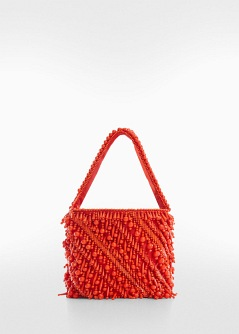

Suggestion 0:
[7991]


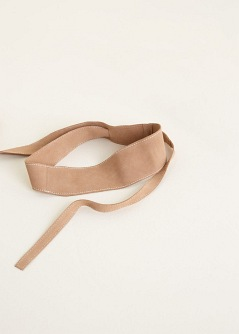

Suggestion 1:
[7991, 2272]


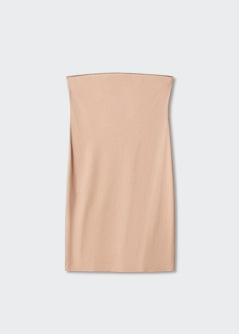

Suggestion 2:
[7991, 2272, 6114]


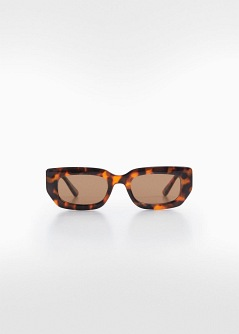

Suggestion 3:
[7991, 2272, 6114, 4474]


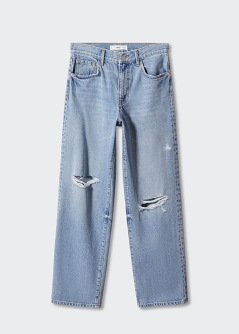

Suggestion 4:
[7991, 2272, 6114, 4474, 317]


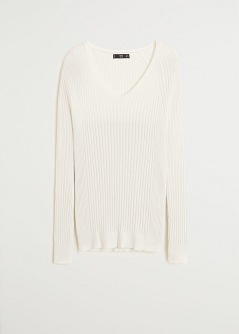

In [79]:
from sklearn.neighbors import NearestNeighbors
file_path = 'item_paths.txt'  # Replace with the actual path to your file

# Read the file and store each line in a list
with open(file_path, 'r') as file:
    lines = [line.strip() for line in file]

knn = NearestNeighbors(n_neighbors=10, metric='euclidean')
knn.fit(X)

def find_nearest_neighbors(indices, X):
    val = X[indices]
    # Predict neighbors
    neighbors = knn.kneighbors(val, return_distance=False)

    return neighbors.flatten()


from PIL import Image
from IPython.display import display
def correct_path(path): #Might add label encoder later
    return path[22:]

index_to_query = [7991]
print("Query Item")

image_path = correct_path(lines[index_to_query[-1]])

# Open the image
image = Image.open(image_path)

# Display the image
display(image)

for i in range(5):

    # Example usage:
    # Replace with the index you want to query
    nearest_neighbors = find_nearest_neighbors(index_to_query, X)[i+1]
    print(f'Suggestion {i}:')
    print(index_to_query)
    index_to_query.append(nearest_neighbors)

    image_path = correct_path(lines[nearest_neighbors])

    # Open the image
    image = Image.open(image_path)

    # Display the image
    display(image)
